In [68]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [119]:
user_rate_df = pd.read_csv('./ml-latest/ratings.csv')
movies_df = pd.read_csv('./ml-latest/movies.csv', index_col=0)
tags_df = pd.read_csv('./ml-latest/genome-tags.csv')
tag_relevance_df = pd.read_csv('./ml-latest/genome-scores.csv')

# Check data & Preprocess

In [120]:
user_rate_df.shape, movies_df.shape, tags_df.shape, tag_relevance_df.shape

((27753444, 4), (58098, 2), (1128, 2), (14862528, 3))

### Ratings.csv

In [121]:
user_rate_df

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [122]:
# drop timestamp / del movieId have not relevance 
user_rate_df = user_rate_df.drop(columns='timestamp')

user_rate_df = user_rate_df[user_rate_df['movieId'].isin(tag_relevance_df.movieId.values)]

user_rate_df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


### Movies.csv

In [123]:
movies_df

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193876,The Great Glinka (1946),(no genres listed)
193878,Les tribulations d'une caissière (2011),Comedy
193880,Her Name Was Mumu (2016),Drama


In [124]:
# chage genres to each genres by one-hot encoding / drop imax
movies_genre_df = movies_df['genres'].str.get_dummies(sep = '|')

movies_genre_df.drop(columns='IMAX', inplace=True)

# drop data have not genres
movies_genre_df = movies_genre_df[movies_genre_df['(no genres listed)'] == 0].drop(columns='(no genres listed)')

movies_genre_df


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193874,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
193878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
193880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Tags.csv

In [126]:
tags_df

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


### Tag Relevance.csv

In [127]:
tag_relevance_df.head()

tag_genre_dict = {'Action': 19, 'Adventure': 29, 'Animation': 64, 'Children': 204, 'Comedy': 230, 'Crime': 268, 'Documentary': 315, 'Drama': 323, 'Fantasy': 377, 'Film-Noir': 393, 'Horror': 522, 'Musical': 686, 'Mystery': 689, 'Romance': 863, 'Sci-Fi': 887, 'Thriller': 1025, 'War': 1096, 'Western': 1107}

tag_rel_small_df = tag_relevance_df[tag_relevance_df['tagId'].isin((pd.DataFrame([tag_genre_dict]).values))]

tag_rel_small_df

,movieId,tagId,relevance
18,1,19,0.66825
28,1,29,0.90700
63,1,64,0.98875
203,1,204,0.95450
229,1,230,0.59475
...,...,...,...
14862262,187595,863,0.26750
14862286,187595,887,0.12850
14862424,187595,1025,0.40150
14862495,187595,1096,0.63700


# Chack User

### Choose the User

In [144]:
# select the user with the 2nd, 3rd and 4th highest number of grade.
user_rate_df.userId.value_counts().head()

123100    9279
117490    6998
242683    6901
212343    6195
63783     5728
Name: userId, dtype: int64

In [145]:
user = 117490

In [129]:
# make df that [ movieId, rating ] of the grade with userId 117490 in the df
user_grade_df = user_rate_df[user_rate_df['userId']==user].iloc[:,1:3]
user_grade_df.head()

,movieId,rating
11445100,1,4.0
11445101,2,4.0
11445102,3,3.0
11445103,4,3.0
11445104,5,3.0


### Filter by user

In [130]:
# movie filter by user
user_movie_df = movies_genre_df.loc[list(set(movies_genre_df.index) & set(user_grade_df.movieId))]
user_movie_df.shape

(6998, 18)

In [135]:
# movie filter by ~user
user_movie_noshow_df = movies_genre_df.loc[list(set(movies_genre_df.index) - set(user_grade_df.movieId))].sort_index()
user_movie_noshow_df = user_movie_noshow_df[user_movie_noshow_df.index.isin(tag_relevance_df.movieId.values)]
user_movie_noshow_df.shape

(6149, 18)

In [136]:
# user rate fileter by movie
user_grade_df = user_grade_df[user_grade_df['movieId'].isin(tag_relevance_df.movieId.values)]
user_grade_df.shape

(6998, 2)

In [138]:
# movie relevance fileter by user
user_relevance_df = tag_rel_small_df[tag_rel_small_df['movieId'].isin(user_grade_df.movieId.values)]
user_relevance_df.shape

(125964, 3)

### Calcurate genre relationship

In [241]:
# calcurate the sum of the genre relationship values for each movie by genre
user_genre_sum_dict = {'Action': 0, 'Adventure': 0, 'Animation': 0, 'Children': 0, 'Comedy': 0, 'Crime': 0, 'Documentary': 0, 'Drama': 0, 'Fantasy': 0, 'Film-Noir': 0, 'Horror': 0, 'Musical': 0, 'Mystery': 0, 'Romance': 0, 'Sci-Fi': 0, 'Thriller': 0, 'War': 0, 'Western': 0}
tag_genre_dict = {'Action': 19, 'Adventure': 29, 'Animation': 64, 'Children': 204, 'Comedy': 230, 'Crime': 268, 'Documentary': 315, 'Drama': 323, 'Fantasy': 377, 'Film-Noir': 393, 'Horror': 522, 'Musical': 686, 'Mystery': 689, 'Romance': 863, 'Sci-Fi': 887, 'Thriller': 1025, 'War': 1096, 'Western': 1107}

for movieId, rating in zip(user_grade_df.movieId, user_grade_df.rating):
    for genre_key in user_genre_sum_dict:
        user_genre_sum_dict[genre_key] += round(rating * user_relevance_df[(user_relevance_df['movieId'] == movieId) & (user_relevance_df['tagId'] == tag_genre_dict[genre_key])].relevance.values[0], 2)
user_genre_sum_dict

{'Action': 5905.789999999997,
 'Adventure': 5472.870000000037,
 'Animation': 1703.9399999999616,
 'Children': 3340.060000000003,
 'Comedy': 5915.759999999983,
 'Crime': 4496.830000000004,
 'Documentary': 1884.7299999999707,
 'Drama': 9762.530000000004,
 'Fantasy': 3954.5099999999848,
 'Film-Noir': 3747.4299999999853,
 'Horror': 1783.409999999887,
 'Musical': 2227.52999999997,
 'Mystery': 2819.4899999999793,
 'Romance': 5818.680000000029,
 'Sci-Fi': 2132.2099999999505,
 'Thriller': 4807.880000000008,
 'War': 2294.7699999999377,
 'Western': 1261.2999999999315}

In [243]:
# calcurate avg of the genre relationship values for each movie by genre
user_genre_avg_dict = {}
for genre_key in user_genre_sum_dict:
    user_genre_avg_dict[genre_key] = round(user_genre_sum_dict[genre_key]/len(user_movie_df), 2)
user_genre_avg_dict

{'Action': 0.84,
 'Adventure': 0.78,
 'Animation': 0.24,
 'Children': 0.48,
 'Comedy': 0.85,
 'Crime': 0.64,
 'Documentary': 0.27,
 'Drama': 1.4,
 'Fantasy': 0.57,
 'Film-Noir': 0.54,
 'Horror': 0.25,
 'Musical': 0.32,
 'Mystery': 0.4,
 'Romance': 0.83,
 'Sci-Fi': 0.3,
 'Thriller': 0.69,
 'War': 0.33,
 'Western': 0.18}

# Recommend

<AxesSubplot: >

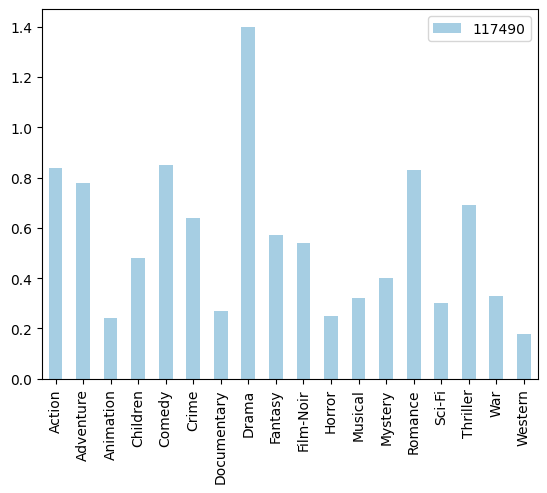

In [257]:
# dict to df
users_genre_rel_df = pd.DataFrame([user_genre_avg_dict], index=[user])
users_genre_rel_df.T.plot(kind='bar', stacked=True ,colormap='Paired')

In [240]:
# for movieId in user_movie_noshow_df.index:
#     for genre_key in tag_genre_dict:
#         if user_movie_noshow_df.loc[movieId, genre_key] == 0:
#             continue
#         user_movie_noshow_df.loc[movieId, genre_key] = user_movie_noshow_df.loc[movieId, genre_key] * tag_rel_small_df[(tag_rel_small_df['movieId'] == movieId) & (tag_rel_small_df['tagId'] == tag_genre_dict[genre_key])].relevance.values[0]
# user_movie_noshow_df
for movieId in user_movie_noshow_df.index:
    for genre_key in tag_genre_dict:
        user_movie_noshow_df.loc[movieId, genre_key] = tag_rel_small_df[(tag_rel_small_df['movieId'] == movieId) & (tag_rel_small_df['tagId'] == tag_genre_dict[genre_key])].relevance.values[0]
user_movie_noshow_df

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,
12,0.13825,0.14250,0.03100,0.01875,0.84875,0.05450,0.01825,0.10475,0.11200,0.09500,0.27925,0.02450,0.05175,0.10825,0.05925,0.04525,0.01775,0.02475
15,0.97800,0.97575,0.03400,0.08225,0.09975,0.03475,0.01600,0.16000,0.40850,0.08700,0.04200,0.03875,0.04500,0.46525,0.13675,0.06225,0.03175,0.02300
33,0.28275,0.52200,0.09650,0.10350,0.11225,0.04450,0.08400,0.54400,0.19350,0.08900,0.01200,0.04025,0.02225,0.16800,0.08325,0.06900,0.03150,0.01475
37,0.21800,0.66875,0.04075,0.05150,0.05800,0.13275,0.21400,0.23800,0.18450,0.10475,0.01550,0.04775,0.07025,0.11825,0.05700,0.08150,0.04875,0.06600
56,0.23575,0.31900,0.16925,0.31750,0.15350,0.09100,0.00575,0.21725,0.57075,0.16050,0.14800,0.06425,0.05600,0.24750,0.21425,0.04625,0.02475,0.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.31150,0.28300,0.11650,0.07925,0.59650,0.10275,0.16075,0.21325,0.29325,0.14125,0.19375,0.06175,0.08125,0.27975,0.13025,0.08050,0.03875,0.04100
185585,0.66300,0.32550,0.06650,0.04775,0.22125,0.07925,0.04150,0.22425,0.21675,0.12375,0.05925,0.06000,0.05200,0.22950,0.55150,0.13250,0.09075,0.03075
186587,0.56400,0.26425,0.10450,0.10175,0.14100,0.24550,0.23775,0.55925,0.18625,0.14225,0.77550,0.07300,0.15000,0.26875,0.56975,0.41200,0.11850,0.04900


In [245]:
#convolution genre_rel and noshow
user_rec_df = users_genre_rel_df.dot(user_movie_noshow_df.T)
user_rec_df.T.sort_values(by=user, ascending=False)


,117490
movieId,
185135,5.811223
131433,5.445840
183701,5.145552
72178,5.045575
134204,4.976465
...,...
5951,0.588197
82684,0.562390
52413,0.542365


# Problem

### the greater the number of genre, the higher the score

In [213]:
'1st-title: ' + movies_df.loc[98243].title, '1st-genre: ' + movies_df.loc[98243].genres, 'last-title: ' + movies_df.loc[51573].title, 'last-genre: ' + movies_df.loc[51573].genres

# '1st-genre: Adventure, Animation, Children, Fantasy

# 'last-genre: Fantasy

('1st-title: Rise of the Guardians (2012)',
 '1st-genre: Adventure|Animation|Children|Fantasy|IMAX',
 'last-title: Meshes of the Afternoon (1943)',
 'last-genre: Fantasy')

### Focus on the superficial genre

In [239]:
'1st: ' + movies_df.loc[135442].genres, '2nd: ' + movies_df.loc[163386].genres, '3rd: ' + movies_df.loc[72603].genres

# '1st: Animation', '2nd: Animation', '3rd: Animation'

('1st: Animation', '2nd: Animation', '3rd: Animation')

# Final Report

In [248]:
'1st: ' + movies_df.loc[185135].title, '2nd: ' + movies_df.loc[131433].title, '3rd: ' + movies_df.loc[183701].title

('1st: Sherlock - A Study in Pink (2010)',
 '2nd: Confession of Murder (2012)',
 '3rd: 12 Strong (2018)')

In [249]:
'1st: ' + movies_df.loc[185135].genres, '2nd: ' + movies_df.loc[131433].genres, '3rd: ' + movies_df.loc[183701].genres

('1st: Crime', '2nd: Action|Thriller', '3rd: Drama|War')